In [1]:
%matplotlib widget
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

import cv2
import skimage as ski
from ipywidgets import interact, IntSlider, FloatSlider, FloatLogSlider
from IPython.display import display, Math

sp.init_printing()

# Transform Visualization

In [79]:
def bw_imshow(img):
    """ plot bw image"""
    with plt.ioff():
        fig, ax = plt.subplots(1, 1, figsize=(9, 9))
        #ax.axis('off')
        ax.imshow(img, cmap="gray", vmin=0, vmax=255)
        display(fig)

def warp(img, H):
    """ apply transformation given by H to image """
    return cv2.warpPerspective(img, H, 2*np.array(img.shape))

def matshow(H):
    display(Math(f'H = {sp.latex(sp.Matrix(np.round(H, 2)))}'))

## Base image

In [ ]:
img = ski.data.camera()
W, H = img.shape
bw_imshow(img)

## Rigid Transform

$$\boldsymbol{H} = \begin{bmatrix} \boldsymbol{R}(\theta) & \boldsymbol{t} \\ \boldsymbol{0}^T & 1\end{bmatrix},$$
where
$$\boldsymbol{R}(\theta) = \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}.$$


 - Preserves parallelism
 - Preserves angles
 - Preserves areas
 - 3 DoF: $\theta, t_x, t_y$

In [ ]:
def rigid_transform(dx=0.0, dy=0.0, theta=0):
    """
    apply rigid transformation to image.
    """
    # construct rotation matrix
    s, c = np.sin(theta*np.pi/180.0), np.cos(theta*np.pi/180.0)
    R = np.array([
        [c, -s],
        [s,  c]
    ])
    t = np.array([(dx, dy)]).T
    L = np.array([(0, 0, 1)])
    H = np.block([[R, t], [L]])

    matshow(H)
    bw_imshow(warp(img, H))
    
    


interact(rigid_transform,
         dx=FloatSlider(min=-W, max=W, step=1, value=0, description='dx'),
         dy=FloatSlider(min=-W, max=W, step=1, value=0, description='dy'),
         theta=FloatSlider(min=-180, max=180, step=5, value=0, description='$\\theta$')
        );

## Similarity Transform

$$\boldsymbol{H} = \begin{bmatrix} s\boldsymbol{R}(\theta) & \boldsymbol{t} \\ \boldsymbol{0}^T & 1\end{bmatrix}.$$

 - Preserves parallelism
 - Preserves angles
 - Isotropic scaling $s$ (positive) disrupts areas
 - 4 DoF: $\theta, t_x, t_y, s$

In [ ]:
def similarity_transform(dx=0.0, dy=0.0, theta=0, scale=1.0):
    """
    apply similarity transformation to image.
    """
    # construct translation vector
    t = np.array([(dx, dy)]).T

    # construct rotation matrix
    s, c = np.sin(theta*np.pi/180.0), np.cos(theta*np.pi/180.0)
    R = np.array([
        [c, -s],
        [s,  c]
    ])

    # homogenous row
    L = np.array([(0, 0, 1)])

    # transformation matrix
    H = np.block([[scale*R, t], [L]])

    bw_imshow(warp(img, H))

interact(similarity_transform,
         dx=FloatSlider(min=-W, max=W, step=1, value=0, description='dx'),
         dy=FloatSlider(min=-W, max=W, step=1, value=0, description='dy'),
         theta=FloatSlider(min=-180, max=180, step=5, value=0, description='$\\theta$'),
         scale=FloatLogSlider(min=-1, max=np.log10(2), step=0.1, value=1, description='s')
        );

## Affine Transform

$$\boldsymbol{H} = \begin{bmatrix} \boldsymbol{A} & \boldsymbol{t} \\ \boldsymbol{0}^T & 1\end{bmatrix},$$
where
$\boldsymbol{A} = \boldsymbol{R}(\theta) \boldsymbol{R}^{-1}(\phi)\begin{bmatrix}k_1 & 0 \\ 0 & k_2 \end{bmatrix}\boldsymbol{R}(\phi).$

 - Preserves parallelism
 - Anisotropic scaling may change angles and areas
 - Negative $k$ allows for reflections
 - 6 DoF: $\theta, t_x, t_y, \phi, k_1, k_2$

In [ ]:
def affine_transform(dx=0.0, dy=0.0, theta=0, phi=0, k1=1, k2=1):
    # construct translation vector
    t = np.array([(dx, dy)]).T

    # construct rotation matrix
    s, c = np.sin(theta*np.pi/180.0), np.cos(theta*np.pi/180.0)
    R = np.array([
        [c, -s],
        [s,  c]
    ])

    # stretching
    s, c = np.sin(phi*np.pi/180.0), np.cos(phi*np.pi/180.0)
    Rs = np.array([
        [c, -s],
        [s,  c]
    ])
    D = np.diag([k1, k2])
    
    # homogenous row
    L = np.array([(0, 0, 1)])

    # transformation matrix
    H = np.block([[R @ Rs @ D @ Rs.T, t], [L]])


    matshow(H)
    bw_imshow(warp(img, H))

interact(affine_transform,
         dx=FloatSlider(min=-W, max=W, step=1, value=0, description='dx'),
         dy=FloatSlider(min=-W, max=W, step=1, value=0, description='dy'),
         theta=FloatSlider(min=-180, max=180, step=5, value=0, description='$\\theta$'),
         phi=FloatSlider(min=0, max=90, step=5, value=0, description='$\\phi$'),
         k1=FloatSlider(min=-3, max=3, step=0.1, value=1, description='$k_1$'),
         k2=FloatSlider(min=-3, max=3, step=0.1, value=1, description='$k_2$'),);

## Projective Transform

$$\boldsymbol{H} = \begin{bmatrix} \boldsymbol{A} & \boldsymbol{t} \\ \boldsymbol{v}^T & v\end{bmatrix},$$
where $v \neq 0$.
 - Able to move infinity points
 - 8 DoF: $\theta, t_x, t_y, \phi, k_1, k_2, v_1, v_2$

In [ ]:
def projective_transform(dx=0.0, dy=0.0, theta=0, phi=0, k1=1, k2=1, v1=0, v2=0):
    # construct translation vector
    t = np.array([(dx, dy)]).T

    # construct rotation matrix
    s, c = np.sin(theta*np.pi/180.0), np.cos(theta*np.pi/180.0)
    R = np.array([
        [c, -s],
        [s,  c]
    ])

    # stretching
    s, c = np.sin(phi*np.pi/180.0), np.cos(phi*np.pi/180.0)
    Rs = np.array([
        [c, -s],
        [s,  c]
    ])
    D = np.diag([k1, k2])
    
    # homogenous row
    L = np.array([(v1, v2, 1)])

    # transformation matrix
    H = np.block([[R @ Rs @ D @ Rs.T, t], [L]])


    matshow(H)
    bw_imshow(warp(img, H))

interact(projective_transform,
         dx=FloatSlider(min=-W, max=W, step=1, value=0, description='dx'),
         dy=FloatSlider(min=-W, max=W, step=1, value=0, description='dy'),
         theta=FloatSlider(min=-180, max=180, step=5, value=0, description='$\\theta$'),
         phi=FloatSlider(min=0, max=90, step=5, value=0, description='$\\phi$'),
         k1=FloatSlider(min=-3, max=3, step=0.1, value=1, description='$k_1$'),
         k2=FloatSlider(min=-3, max=3, step=0.1, value=1, description='$k_2$'),
         v1=FloatSlider(min=-0.01, max=0.01, step=0.001, value=0, description='$v_1$'),
         v2=FloatSlider(min=-0.01, max=0.01, step=0.001, value=0, description='$v_2$'),);

# Application example

A point in the infinity may be mapped to a finite point in image space.
A common example is horizon lines being visible in pictures.

If we want to warp our image so that a particular plane in space appears "frontal", it is sufficient to map ideal points
in that plane to improper points of the image.

Suppose that $$\bf l = \begin{bmatrix} l_1 \\ l_2 \\ l_3 \end{bmatrix}$$ is the ideal line as seen in our image.
Then consider the projective transform $$\boldsymbol{H}_P =
    \begin{bmatrix} 1 & 0 & 0\\0 & 1 & 0\\ l_1 & l_2 & l_3 \end{bmatrix}.$$
This transform is a transform that maps $\boldsymbol{l}$ to $\begin{bmatrix} 0 \\ 0 \\ 1 \end{bmatrix}$, since lines are transformed
through $\boldsymbol{l}' = \boldsymbol{H} ^{-T}\boldsymbol{l}$.

In [2]:
img = ski.io.imread("https://upload.wikimedia.org/wikipedia/commons/9/95/Tiled_floor_of_the_Passage_des_Princes_%28Paris%29.jpg")

On the figure below, click on pairs of points that form parallel lines.
Once 4 lines are formed, we can compute the homography.

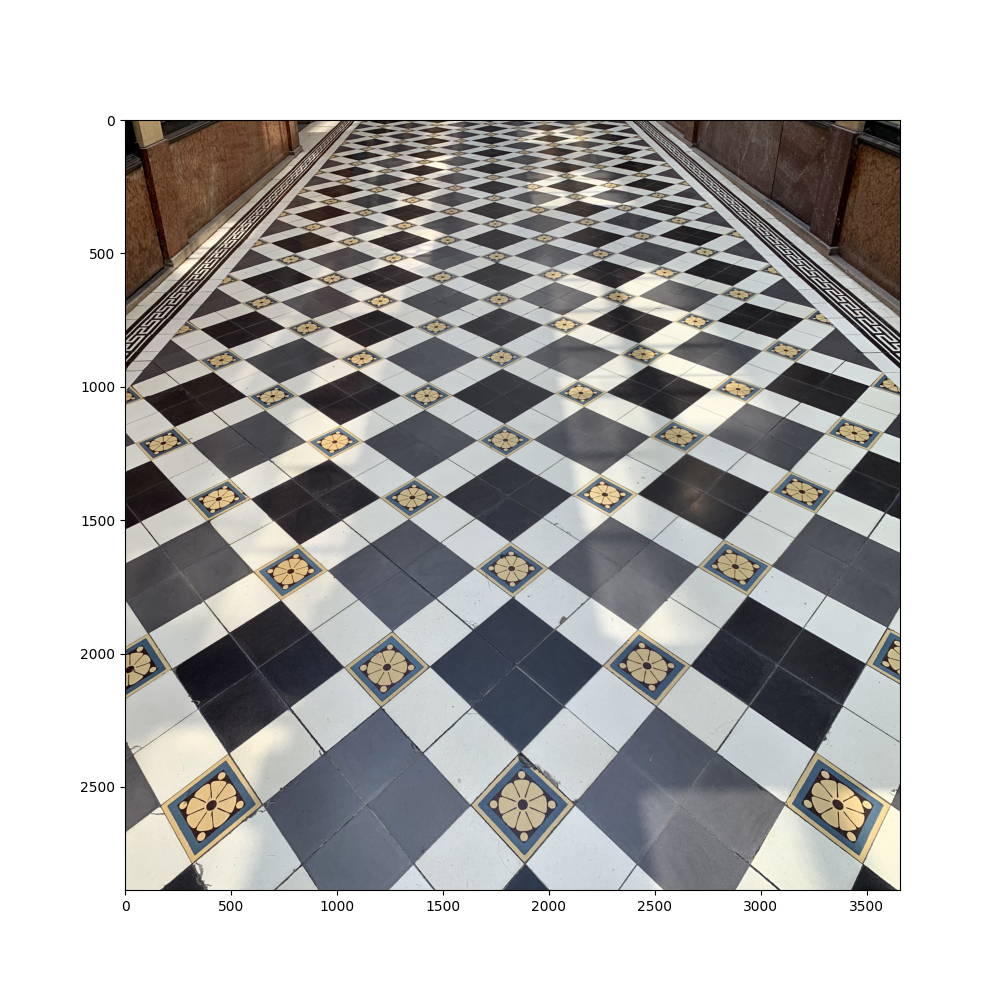

In [170]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, aspect='auto')

projective_points = []

def onclick(event):
    if len(projective_points) < 8:
        position = (event.xdata, event.ydata)
        projective_points.append(position)
        plt.scatter(*position)

        if (len(projective_points) % 2) == 0:
            a, b = projective_points[-2], projective_points[-1]
            plt.plot([a[0], b[0]], [a[1], b[1]])
    else:
        plt.disconnect(binding_id)

binding_id = plt.connect('button_press_event', onclick)

In [171]:
def compute_projection(points):
    lines = []
    for a, b in zip(points[0::2], points[1::2]):
        a, b = [*a, 1], [*b, 1]
        l = np.cross(a, b)
        lines.append(l / l[-1])
    ideal_points = []
    for l, m in zip(lines[0::2], lines[1::2]):
        p = np.cross(l, m)
        ideal_points.append(p / p[-1])
    l = np.cross(ideal_points[0], ideal_points[1])
    l /= l[-1]
    l
    H = np.eye(3)
    H[-1, :] = l
    return H

In [172]:
def compute_bounds(points, H):
    h_points = np.array([[*p, 1] for p in points]).T
    transformed_points = H @ h_points
    transformed_points /= transformed_points[-1]
    W, H, _ = np.max(transformed_points, axis=-1)
    return (int(W), int(H))

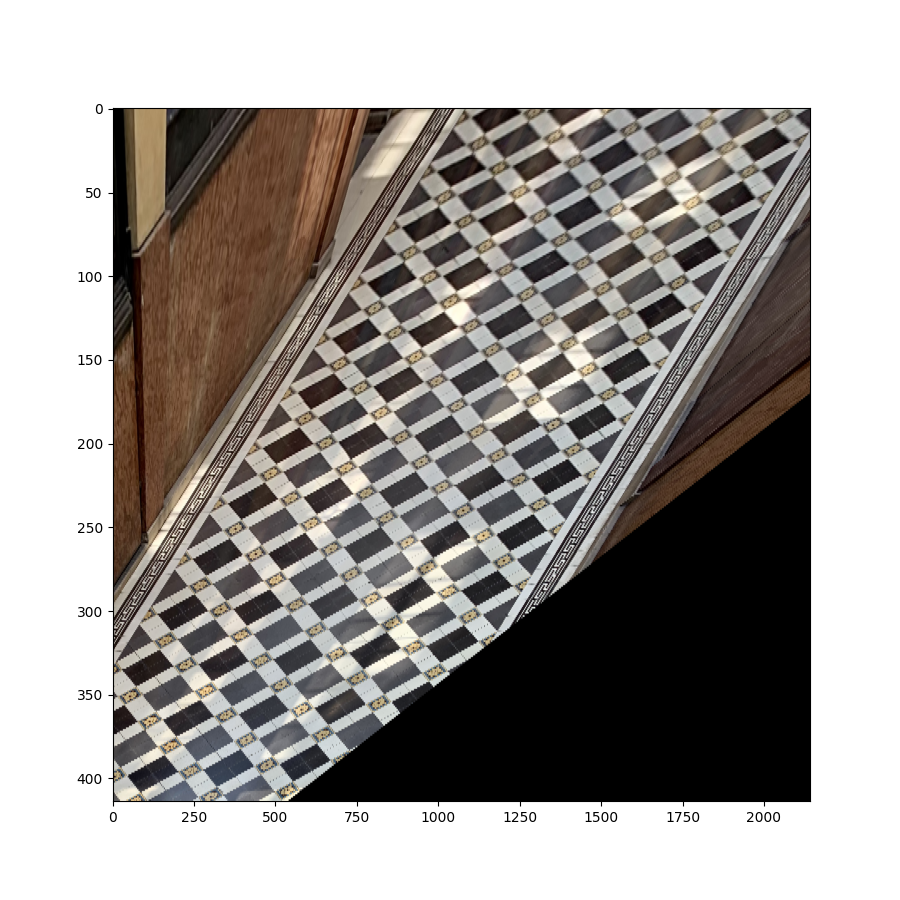

In [174]:
H_p    = compute_projection(points)
bounds = compute_bounds(points, H_p)
warped = cv2.warpPerspective(img, H_p, bounds)
plt.figure(figsize=(9, 9))
plt.imshow(warped, aspect='auto');